In [1]:
!pip install openai==0.28.1
#Gets the number of tokens and computes price
!pip install tiktoken==0.6.0
# langchain
!pip install langchain==0.1.20

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.52.2
    Uninstalling openai-1.52.2:
      Successfully uninstalled openai-1.52.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully unins

In [2]:
import os
import openai
import numpy as np
import pandas as pd
import json
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from openai.embeddings_utils import get_embedding

In [3]:
openai.api_key = "OPENAI_API_KEY"

In [4]:
from google.colab import userdata
# Retrieve the API key directly from Colab's secret storage
openai.api_key = userdata.get("OPENAI_API_KEY")

In [ ]:
# OS way of incorporating api key
#os.environ['OPENAI_API_KEY'] = "OPENAI_API_KEY"

In [5]:
dataframed = pd.read_csv('https://raw.githubusercontent.com/AI-Republic-PH/AIR_AI_Engineering_Course_2024/refs/heads/main/Datasets/IMDB_Dataset.csv', nrows=20)

In [6]:
dataframed.head(20)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


Goal is to make the chatbot give reviews

In [7]:
dataframed['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [8]:
System_Prompt = """
You are an advanced sentiment analysis tool designed to classify movie reviews from the IMDB dataset based on sentiment. The user will provide reviews, and your task is to categorize each one as either "Positive" or "Negative." Your response should be concise and strictly limited to "Positive" or "Negative" based on the sentiment expressed in each review.

Guidelines for Sentiment Classification
Response Format: Only respond with "Positive" or "Negative" depending on whether the review generally expresses a favorable or unfavorable sentiment.

Sentiment Evaluation Criteria:

Positive: If the review communicates enjoyment, praise, excitement, or satisfaction, classify it as "Positive."
Negative: If the review conveys disappointment, criticism, dissatisfaction, or regret, classify it as "Negative."
Handling Ambiguity:

Dominant Sentiment: If a review includes both positive and negative points, assess which sentiment is more dominant overall and respond accordingly.
Balanced Sentiment: For reviews where the positive and negative sentiments appear equally strong (e.g., "It had great visuals but was too slow to keep my interest"), default to "Negative."
Neutral or Vague Sentiment: If the sentiment is unclear or overly neutral (e.g., “It was okay” or “The movie was interesting”), classify it as "Negative" unless there is a clear positive leaning.
Examples for Reference
Clear Sentiment Examples
Positive:

"I absolutely loved this movie! The story was captivating and the actors did an amazing job."
"A fantastic experience! The visuals were stunning, and I was engaged from start to finish."
Negative:

"The movie was disappointing. The plot was weak, and I couldn't connect with the characters."
"I expected more. The pacing was terrible, and the acting felt forced."
Ambiguous Sentiment Examples
Ambiguous but Dominant Positive:

"The story had some weak points, but overall, I really enjoyed it and would watch it again."
Response: Positive
Ambiguous but Dominant Negative:

"The acting was decent, but the storyline was all over the place, and I left the theater disappointed."
Response: Negative
Balanced Sentiment (Lean Negative):

"The action scenes were thrilling, but the plot was confusing and hard to follow."
Response: Negative
Neutral or Vague Sentiment (Default to Negative):

"It was alright, not the best but not the worst either."
Response: Negative
Additional Guidelines
Consistency: Maintain consistency in evaluating reviews by following the guidelines above to avoid varying responses to similar sentiment patterns.
Avoid Overthinking Subtle Nuances: Focus on the clear sentiment direction. If the review has mixed sentiment, prioritize the dominant feeling without over-analyzing specific phrases.
No Explanations Needed: Remember that each response should consist solely of "Positive" or "Negative," with no additional text, elaborations, or commentary.
Objective Focus: Do not interpret subjective terms (like “interesting”) as positive unless supported by other positive sentiments. Default to "Negative" in cases of uncertainty.
"""

In [9]:
struct = [{"role": "system", "content": System_Prompt}]

user_message = dataframed['review'][0]
print("User:", user_message)
struct.append({"role" : "user", "content" : user_message})
chat = openai.ChatCompletion.create(model="gpt-4o-mini", messages = struct)
response = chat.choices[0].message.content
struct.append({"role" : "assistant", "content" : user_message})
print("Assistant:", response)

User: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to t

In [10]:
dataframed["Openai_Sentiment"] = ''

In [11]:
for x in range(min(20, len(dataframed))):
    struct = [{'role': 'system', 'content': System_Prompt}]
    user_message = dataframed['review'].iloc[x]
    print("User:", user_message)
    struct.append({'role': 'user', 'content': user_message})
    chat = openai.ChatCompletion.create(model="gpt-4o-mini", messages=struct)
    reply = chat.choices[0].message.content
    struct.append({"role": "assistant", "content": reply})
    # Use .loc to avoid the FutureWarning
    dataframed.loc[x, 'Openai_sentiment'] = reply

User: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to t

In [ ]:
dataframed.head(20)

,review,sentiment,Openai_Sentiment
0,One of the other reviewers has mentioned that ...,positive,Positive
1,A wonderful little production. <br /><br />The...,positive,Positive
2,I thought this was a wonderful way to spend ti...,positive,Positive
3,Basically there's a family where a little boy ...,negative,Negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Positive
5,"Probably my all-time favorite movie, a story o...",positive,Positive
6,I sure would like to see a resurrection of a u...,positive,Positive
7,"This show was an amazing, fresh & innovative i...",negative,Negative
8,Encouraged by the positive comments about this...,negative,Negative
9,If you like original gut wrenching laughter yo...,positive,Positive


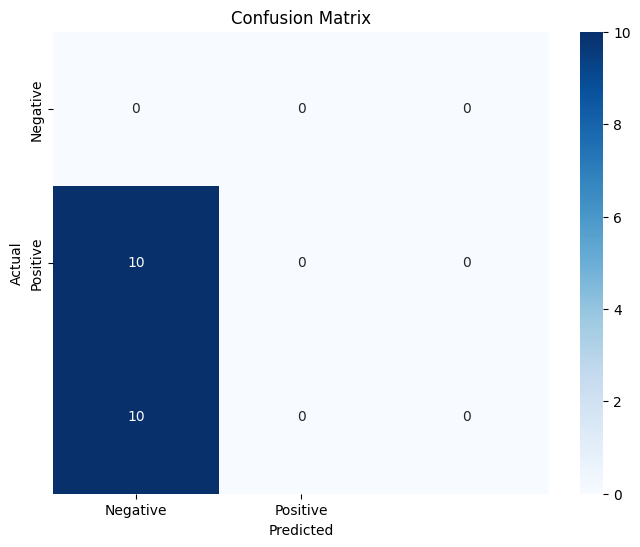

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 'sentiment' column contains actual sentiments and 'Openai_Sentiment' contains predicted sentiments
cm = confusion_matrix(dataframed['sentiment'], dataframed['Openai_Sentiment'])

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#prompt_tokens = response['usage']['prompt_tokens']
#completion_tokens = response['usage']['completion_tokens']
#total_tokens = response['usage']['total_tokens']
#print(total_tokens)